## **EN3150 Assignment 03:**
### **Simple convolutional neural network to perform classification.**

In [8]:
# Import necessary Libraries
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, datasets, models
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [9]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [10]:
# Data preparation
data_dir = r"C:\Users\ADMIN\Desktop\Mora\Image Dataset\realwaste-main\RealWaste"

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load dataset
full_dataset = datasets.ImageFolder(root=data_dir, transform=train_transform)
class_names = full_dataset.classes
print("Classes:", class_names)

# Split 70/15/15
total_len = len(full_dataset)
train_len = int(0.7 * total_len)
val_len = int(0.15 * total_len)
test_len = total_len - train_len - val_len
train_ds, val_ds, test_ds = random_split(full_dataset, [train_len, val_len, test_len])
val_ds.dataset.transform = val_test_transform
test_ds.dataset.transform = val_test_transform

# DataLoaders optimized for your hardware
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=4)


Classes: ['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation']


In [11]:
# Define a simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=len(class_names)):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(128 * (224 // 8) * (224 // 8), 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

In [12]:
# Training and evaluation functions
def train_model(model, optimizer, criterion, train_loader, val_loader, epochs=20):
    train_losses, val_losses = [], []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            loss = criterion(model(inputs), labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                val_loss += criterion(model(inputs), labels).item()
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        print(f"Epoch [{epoch+1}/{epochs}]  Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    return train_losses, val_losses

def evaluate_model(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
    acc = np.mean(np.array(all_preds) == np.array(all_labels))
    prec = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    rec = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    cm = confusion_matrix(all_labels, all_preds)
    return acc, prec, rec, cm


===== Training with Adam =====
Epoch [1/20]  Train Loss: 1.8308 | Val Loss: 1.5658
Epoch [2/20]  Train Loss: 1.3266 | Val Loss: 1.1799
Epoch [3/20]  Train Loss: 1.1066 | Val Loss: 1.1125
Epoch [4/20]  Train Loss: 0.9461 | Val Loss: 0.9395
Epoch [5/20]  Train Loss: 0.7952 | Val Loss: 0.9938
Epoch [6/20]  Train Loss: 0.6440 | Val Loss: 0.8620
Epoch [7/20]  Train Loss: 0.5669 | Val Loss: 0.8984
Epoch [8/20]  Train Loss: 0.4394 | Val Loss: 0.9038
Epoch [9/20]  Train Loss: 0.4027 | Val Loss: 0.9144
Epoch [10/20]  Train Loss: 0.3461 | Val Loss: 1.0928
Epoch [11/20]  Train Loss: 0.3035 | Val Loss: 1.0353
Epoch [12/20]  Train Loss: 0.2482 | Val Loss: 1.2778
Epoch [13/20]  Train Loss: 0.2309 | Val Loss: 1.2576
Epoch [14/20]  Train Loss: 0.2039 | Val Loss: 1.1252
Epoch [15/20]  Train Loss: 0.1915 | Val Loss: 1.1540
Epoch [16/20]  Train Loss: 0.1548 | Val Loss: 1.2230
Epoch [17/20]  Train Loss: 0.1256 | Val Loss: 1.1483
Epoch [18/20]  Train Loss: 0.1321 | Val Loss: 1.1536
Epoch [19/20]  Train Lo

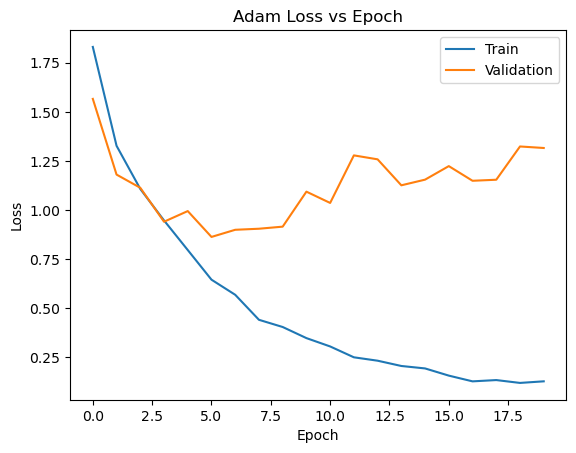


===== Training with SGD =====
Epoch [1/20]  Train Loss: 2.0581 | Val Loss: 1.8530
Epoch [2/20]  Train Loss: 1.7829 | Val Loss: 1.5904
Epoch [3/20]  Train Loss: 1.5947 | Val Loss: 1.5025
Epoch [4/20]  Train Loss: 1.4777 | Val Loss: 1.3992
Epoch [5/20]  Train Loss: 1.3575 | Val Loss: 1.2758
Epoch [6/20]  Train Loss: 1.2926 | Val Loss: 1.2398
Epoch [7/20]  Train Loss: 1.2274 | Val Loss: 1.2967
Epoch [8/20]  Train Loss: 1.1555 | Val Loss: 1.1212
Epoch [9/20]  Train Loss: 1.0763 | Val Loss: 1.1094
Epoch [10/20]  Train Loss: 1.0414 | Val Loss: 1.0523
Epoch [11/20]  Train Loss: 0.9931 | Val Loss: 1.1509
Epoch [12/20]  Train Loss: 0.9302 | Val Loss: 1.0510
Epoch [13/20]  Train Loss: 0.8879 | Val Loss: 1.0064
Epoch [14/20]  Train Loss: 0.8264 | Val Loss: 0.9944
Epoch [15/20]  Train Loss: 0.7860 | Val Loss: 0.9987
Epoch [16/20]  Train Loss: 0.7455 | Val Loss: 0.9586
Epoch [17/20]  Train Loss: 0.7075 | Val Loss: 0.9489
Epoch [18/20]  Train Loss: 0.6725 | Val Loss: 0.9195
Epoch [19/20]  Train Los

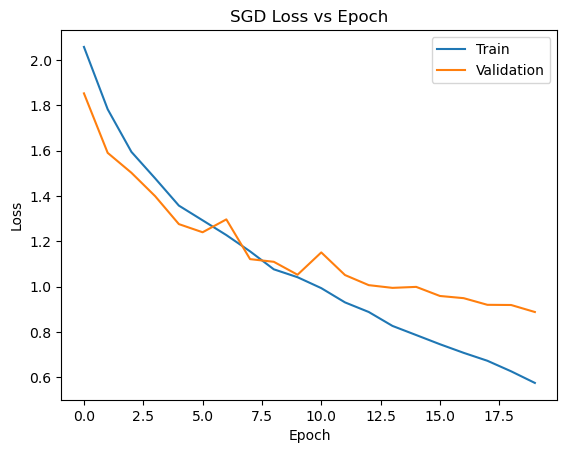


===== Training with SGD+Momentum =====
Epoch [1/20]  Train Loss: 1.9541 | Val Loss: 1.6211
Epoch [2/20]  Train Loss: 1.6177 | Val Loss: 1.4888
Epoch [3/20]  Train Loss: 1.4502 | Val Loss: 1.4028
Epoch [4/20]  Train Loss: 1.3107 | Val Loss: 1.2231
Epoch [5/20]  Train Loss: 1.1789 | Val Loss: 1.1628
Epoch [6/20]  Train Loss: 1.0353 | Val Loss: 1.2476
Epoch [7/20]  Train Loss: 0.9594 | Val Loss: 1.0873
Epoch [8/20]  Train Loss: 0.7721 | Val Loss: 1.0685
Epoch [9/20]  Train Loss: 0.6754 | Val Loss: 1.2358
Epoch [10/20]  Train Loss: 0.5629 | Val Loss: 1.2134
Epoch [11/20]  Train Loss: 0.4711 | Val Loss: 1.2808
Epoch [12/20]  Train Loss: 0.3870 | Val Loss: 1.4006
Epoch [13/20]  Train Loss: 0.3261 | Val Loss: 1.4783
Epoch [14/20]  Train Loss: 0.2651 | Val Loss: 1.4349
Epoch [15/20]  Train Loss: 0.2486 | Val Loss: 1.4727
Epoch [16/20]  Train Loss: 0.1977 | Val Loss: 1.6844
Epoch [17/20]  Train Loss: 0.2917 | Val Loss: 1.6123
Epoch [18/20]  Train Loss: 0.2494 | Val Loss: 1.6546
Epoch [19/20]  

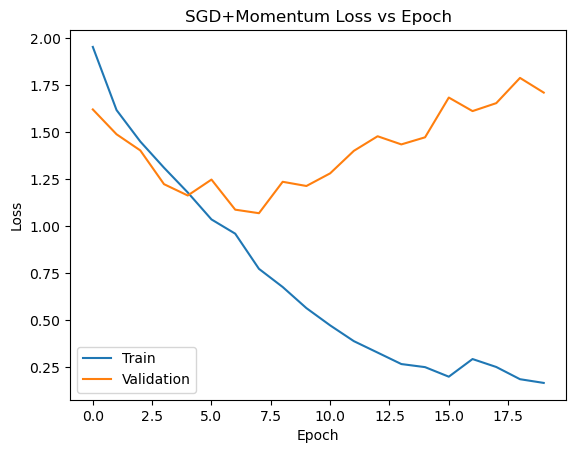

In [13]:
# Train the model with optimizers Adam, SGD and SGD with momentum
criterion = nn.CrossEntropyLoss()
optimizers = {
    "Adam": lambda params: optim.Adam(params, lr=0.001),
    "SGD": lambda params: optim.SGD(params, lr=0.01),
    "SGD+Momentum": lambda params: optim.SGD(params, lr=0.01, momentum=0.9)
}

results = {}
for name, opt_fn in optimizers.items():
    print(f"\n===== Training with {name} =====")
    model = SimpleCNN().to(device)
    optimizer = opt_fn(model.parameters())
    train_losses, val_losses = train_model(model, optimizer, criterion, train_loader, val_loader, epochs=20)
    acc, prec, rec, cm = evaluate_model(model, test_loader)
    results[name] = (acc, prec, rec, cm)
    plt.figure()
    plt.plot(train_losses, label='Train')
    plt.plot(val_losses, label='Validation')
    plt.title(f'{name} Loss vs Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()



Adam Results:
Accuracy: 69.47% | Precision: 0.707 | Recall: 0.690


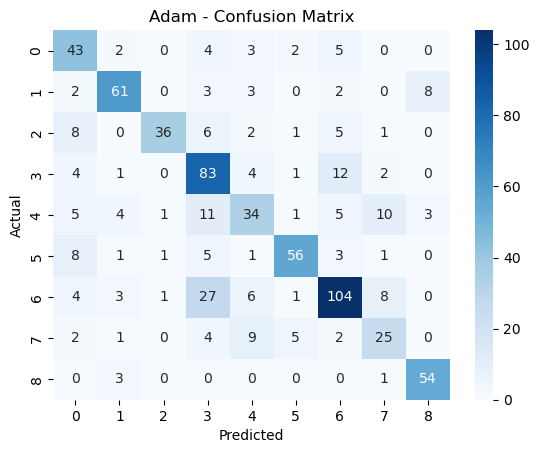


SGD Results:
Accuracy: 64.43% | Precision: 0.660 | Recall: 0.641


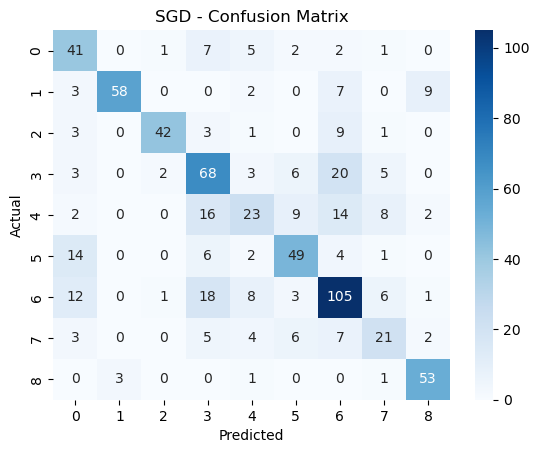


SGD+Momentum Results:
Accuracy: 63.59% | Precision: 0.654 | Recall: 0.628


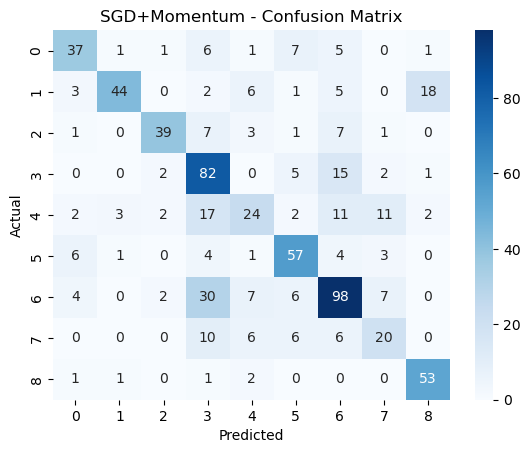

In [14]:
# Results 
for name, (acc, prec, rec, cm) in results.items():
    print(f"\n{name} Results:")
    print(f"Accuracy: {acc*100:.2f}% | Precision: {prec:.3f} | Recall: {rec:.3f}")
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name} - Confusion Matrix')
    plt.xlabel('Predicted'); plt.ylabel('Actual')
    plt.show()


===== Fine-tuning ResNet18 =====
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\ADMIN/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


c:\Users\ADMIN\anaconda3\envs\spiralmlp\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ADMIN\anaconda3\envs\spiralmlp\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 44.7M/44.7M [00:25<00:00, 1.86MB/s]


Epoch [1/10]  Train Loss: 1.4859 | Val Loss: 1.0442
Epoch [2/10]  Train Loss: 0.9366 | Val Loss: 0.8919
Epoch [3/10]  Train Loss: 0.7842 | Val Loss: 0.8712
Epoch [4/10]  Train Loss: 0.7152 | Val Loss: 0.7604
Epoch [5/10]  Train Loss: 0.6462 | Val Loss: 0.7453
Epoch [6/10]  Train Loss: 0.6196 | Val Loss: 0.6970
Epoch [7/10]  Train Loss: 0.5837 | Val Loss: 0.7153
Epoch [8/10]  Train Loss: 0.5659 | Val Loss: 0.6858
Epoch [9/10]  Train Loss: 0.5251 | Val Loss: 0.6686
Epoch [10/10]  Train Loss: 0.5278 | Val Loss: 0.6919
ResNet18 Fine-tuned Accuracy: 78.71%


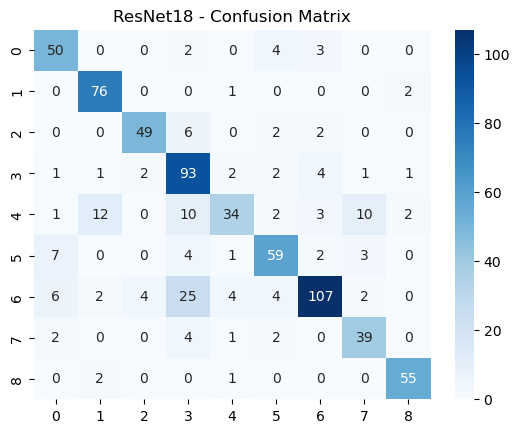


===== Fine-tuning VGG16 =====


c:\Users\ADMIN\anaconda3\envs\spiralmlp\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ADMIN\anaconda3\envs\spiralmlp\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\ADMIN/.cache\torch\hub\checkpoints\vgg16-397923af.pth


100%|██████████| 528M/528M [09:00<00:00, 1.02MB/s] 


Epoch [1/10]  Train Loss: 1.0607 | Val Loss: 0.7309
Epoch [2/10]  Train Loss: 0.7120 | Val Loss: 0.6604
Epoch [3/10]  Train Loss: 0.6520 | Val Loss: 0.6231
Epoch [4/10]  Train Loss: 0.5746 | Val Loss: 0.6219
Epoch [5/10]  Train Loss: 0.5669 | Val Loss: 0.6044
Epoch [6/10]  Train Loss: 0.5386 | Val Loss: 0.5613
Epoch [7/10]  Train Loss: 0.4961 | Val Loss: 0.5363
Epoch [8/10]  Train Loss: 0.5066 | Val Loss: 0.5519
Epoch [9/10]  Train Loss: 0.4683 | Val Loss: 0.5484
Epoch [10/10]  Train Loss: 0.4481 | Val Loss: 0.5145
VGG16 Fine-tuned Accuracy: 80.39%


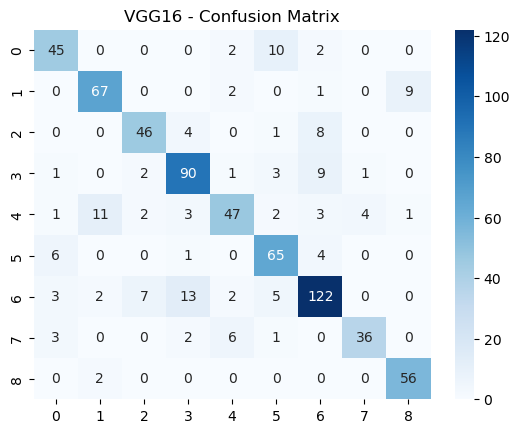

In [15]:
# Transfer learning using ResNet18
print("\n===== Fine-tuning ResNet18 =====")
resnet = models.resnet18(pretrained=True)
for param in resnet.parameters():
    param.requires_grad = False
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, len(class_names))
resnet = resnet.to(device)

optimizer_ft = optim.Adam(resnet.fc.parameters(), lr=0.001)
train_model(resnet, optimizer_ft, criterion, train_loader, val_loader, epochs=10)
acc_ft, prec_ft, rec_ft, cm_ft = evaluate_model(resnet, test_loader)
print(f"ResNet18 Fine-tuned Accuracy: {acc_ft*100:.2f}%")
sns.heatmap(cm_ft, annot=True, fmt='d', cmap='Blues')
plt.title('ResNet18 - Confusion Matrix')
plt.show()

# Trasnfer Learning using VGG16
print("\n===== Fine-tuning VGG16 =====")
vgg16 = models.vgg16(pretrained=True)
for param in vgg16.parameters():
    param.requires_grad = False
num_ftrs = vgg16.classifier[6].in_features
vgg16.classifier[6] = nn.Linear(num_ftrs, len(class_names))
vgg16 = vgg16.to(device)

optimizer_ft = optim.Adam(vgg16.classifier[6].parameters(), lr=0.001)
train_model(vgg16, optimizer_ft, criterion, train_loader, val_loader, epochs=10)
acc_ft, prec_ft, rec_ft, cm_ft = evaluate_model(vgg16, test_loader)
print(f"VGG16 Fine-tuned Accuracy: {acc_ft*100:.2f}%")
sns.heatmap(cm_ft, annot=True, fmt='d', cmap='Blues')
plt.title('VGG16 - Confusion Matrix')
plt.show()